# AI4I 2020 Classification  
Dataset: [AI4I 2020 Predictive Maintenance](https://doi.org/10.24432/C5HS5C)  
Reference: Shah et al. (2024), IEEE Xplore  
This notebook replicates the phase 1 analysis of Shah et al., using Random Forest, Support Vector Machine, and Logistic Regression to predict machine failure using the AI4I 2020 dataset.


## Data Aquisition

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('ai4i2020.csv')
df.info()
df.head(), df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 703.3+ KB


(   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  
 0                    1551         42.8                0                0  
 1                    1408         46.3                3                0  
 2                    1498         49.4                5                0  
 3                    1433         39.5                7                0  
 4                    1408         40.0                9                0  ,
         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 9995   9996     M24855  

### License & Ethical Use
- The dataset is synthetic, designed for research and academic purposes.
- No real personal data is included.

## Data Exploration

In [13]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


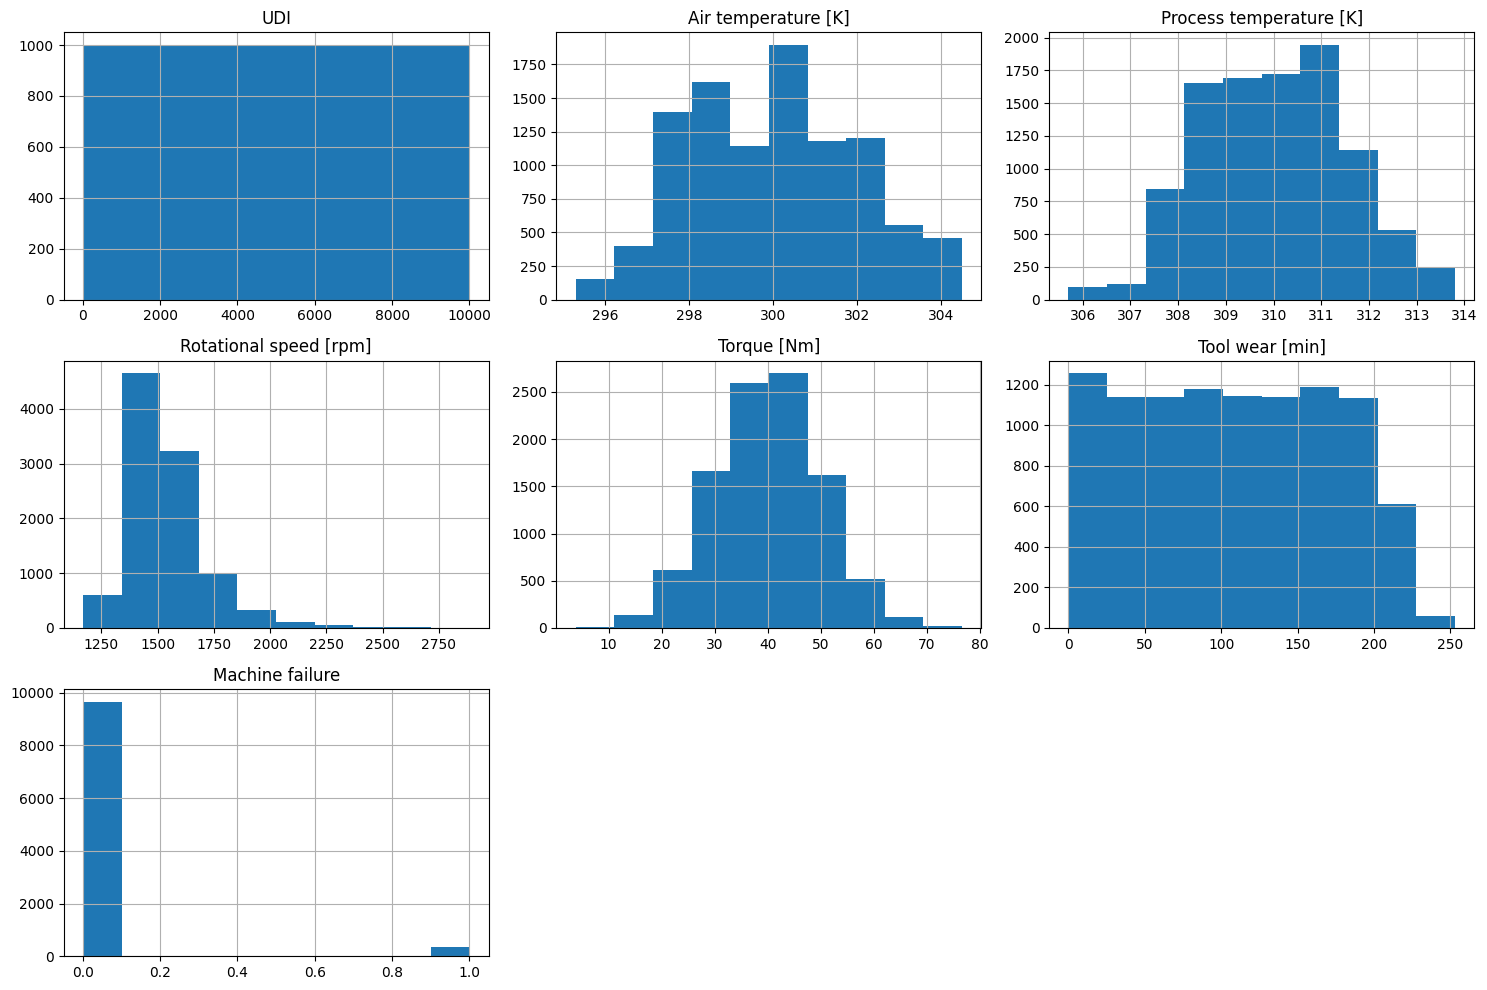

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

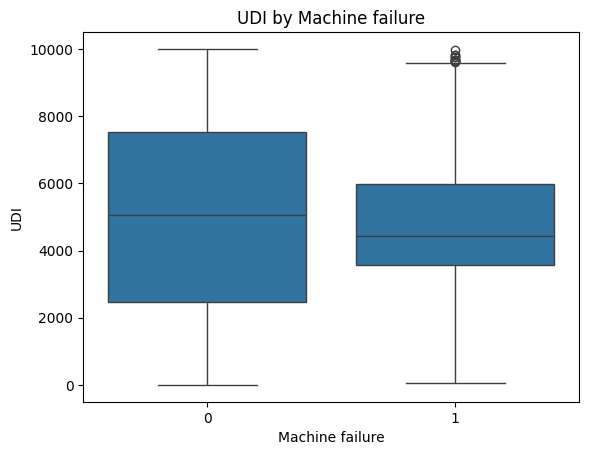

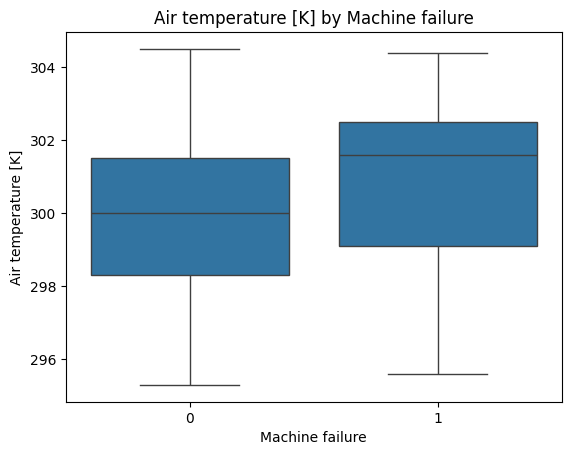

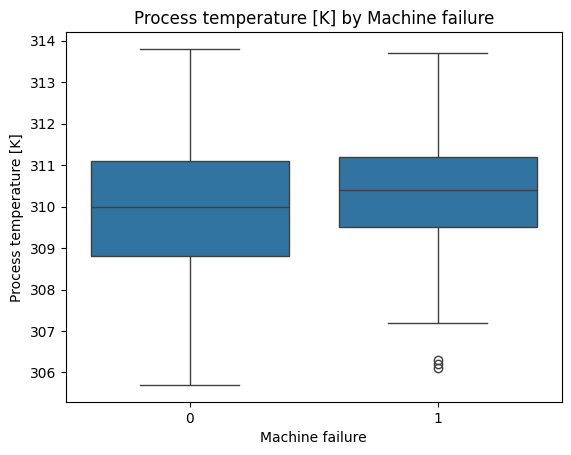

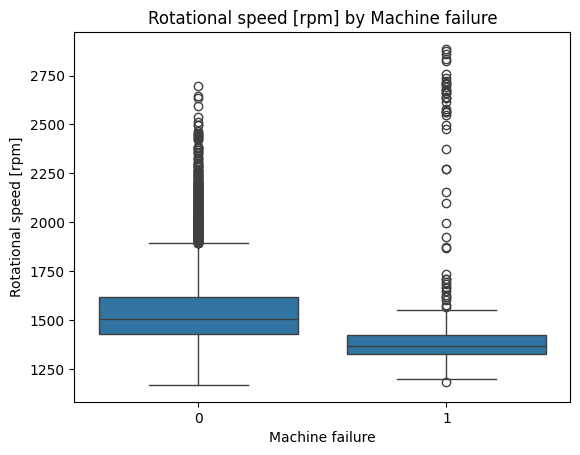

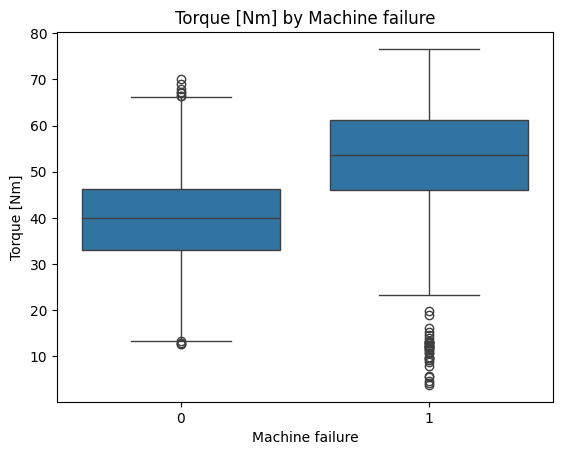

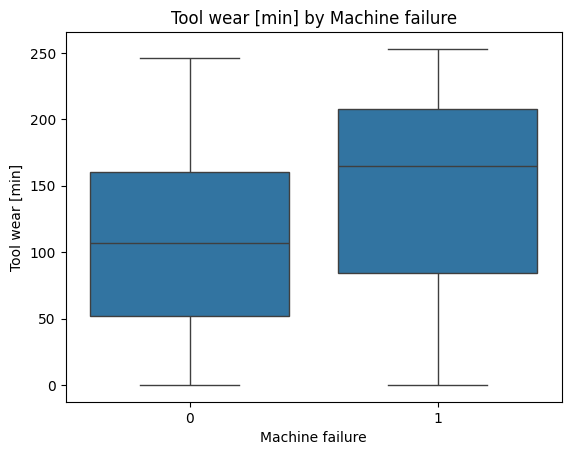

In [15]:
for col in df.select_dtypes(include='number').columns[:-1]:
    sns.boxplot(x='Machine failure', y=col, data=df)
    plt.title(f'{col} by Machine failure')
    plt.show()

In [16]:
df['Machine failure'].value_counts(normalize=True) * 100

Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64

## Data preprocessing

In [17]:
df_cleaned = df.drop(columns=['UDI', 'Product ID', 'Type'])  # Drop irrelevant columns
df_model = df_cleaned.copy()

## Model Creation

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df_model.drop(columns=['Machine failure'])
y = df_model['Machine failure']

# 80/20 stratified split as used by Shah et al.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [23]:
# Parameter grids for tuning
rf_params = {'n_estimators': [100], 'max_depth': [10]}
svm_params = {'C': [1], 'kernel': ['rbf']}
lr_params = {'C': [1]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=cv)
svm = GridSearchCV(SVC(probability=True), svm_params, cv=cv)
lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=cv)

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
lr.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1]})

In [24]:
# Results from all models
for name, model in [('Random Forest', rf), ('SVM', svm), ('Logistic Regression', lr)]:
    print(f"{name} - Best Params: {model.best_params_}")
    print(f"{name} - CV Score: {model.best_score_:.4f}")
    y_pred = model.predict(X_test)
    print(f"{name} - Classification Report:\n", classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


Random Forest - Best Params: {'max_depth': 10, 'n_estimators': 100}
Random Forest - CV Score: 0.9817
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.63      0.73        68

    accuracy                           0.98      2000
   macro avg       0.92      0.81      0.86      2000
weighted avg       0.98      0.98      0.98      2000

[[1925    7]
 [  25   43]]
SVM - Best Params: {'C': 1, 'kernel': 'rbf'}
SVM - CV Score: 0.9664
SVM - Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       1.00      0.01      0.03        68

    accuracy                           0.97      2000
   macro avg       0.98      0.51      0.51      2000
weighted avg       0.97      0.97      0.95      2000

[[1932    0]
 [  67    1]]
Logistic Regression - Best Params: {'C': 1}
Logistic 

## Evaluation and Recommendation

### Critique of Shah et al. (2024)
- Used 80:20 split and classic models (RF, SVM, LR).
- Models were evaluated with Accuracy, Precision, Recall, F1, AUC-ROC.
- RF slightly outperformed the others, especially on high and medium-quality machines.
- Phase 1 didn't explore hyperparameter tuning broadly or feature selection.

### Self-Evaluation
- Reproduced their Phase 1 setup with tuning via GridSearchCV and cross-validation.
- Logistic Regression showed good baseline performance but lower F1 score.
- Further improvement may come from balancing the dataset and feature engineering.

### Model Exportation

In [21]:
import pickle
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(rf.best_estimator_, f)